In [1]:
import matplotlib.pyplot as plt

from datasets import SyntheticDataset
from crowd_evaluation import OldEvaluator, ConfidenceEvaluatorC, MajorityEvaluator, VoteAggregator
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from visualizations.utils import say

In [2]:
from joblib import Memory, Parallel, delayed
memory = Memory('accuracy_vs_num_samples', verbose=0)

@memory.cache
def calc_fraction_of_wrong_interval_estimates(
        num_samples: int,
        num_workers: int,
        confidence: float,
        evaluator_name: str,
        iter_count: int,
        error_rates: list[int]):

    correct_interval_estimates = np.zeros(iter_count * num_workers, dtype=np.float32)
    error_rate_estimation_errors = np.zeros(iter_count * num_workers, dtype=np.float32)
    int_sizes = np.zeros(iter_count * num_workers, dtype=np.float32)

    # Saves for every sample generated whether the
    # majority vote estimates the label correctly (=1) or not (=0)
    majority_vote_estimations = np.zeros(iter_count * num_samples)

    # Saves for every sample generated whether the
    # weighted vote estimates the label correctly (=1) or not (=0)
    weighted_vote_estimations = np.zeros(iter_count * num_samples)

    for i in range(iter_count):
        p_true = np.random.choice(error_rates, size=num_workers)
        dataset = SyntheticDataset(num_samples=num_samples, num_workers=num_workers, p_true=p_true)

        if evaluator_name == 'old':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='exhaustive'
            )
        elif evaluator_name == 'old greedy':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='greedy'
            )
        elif evaluator_name == 'majority':
            evaluator = MajorityEvaluator(dataset)
            ps = evaluator.evaluate_workers(dataset.workers)
            confs = np.zeros(num_workers)
        else:
            evaluator = ConfidenceEvaluatorC(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
            )


        ground_truth = dataset.get_ground_truth_for_samples(dataset.samples)
        maj_vote = VoteAggregator.majority_vote(dataset, dataset.samples)
        weighted_vote = VoteAggregator.weighted_vote(dataset, dataset.samples, ps, 0.5)

        min_limit, max_limit = ps-confs, ps+confs
        correct_interval_estimates[i*num_workers:(i+1)*num_workers] = np.where((min_limit <= p_true) & (p_true <= max_limit), 1, 0)
        int_sizes[i*num_workers:(i+1)*num_workers] = 2*confs
        error_rate_estimation_errors[i*num_workers:(i+1)*num_workers] = np.abs(ps - p_true)

        majority_vote_estimations[i*num_samples:(i+1)*num_samples] = (ground_truth == maj_vote)
        weighted_vote_estimations[i*num_samples:(i+1)*num_samples] = (ground_truth == weighted_vote)

    return correct_interval_estimates, int_sizes, error_rate_estimation_errors, majority_vote_estimations, weighted_vote_estimations

In [3]:
from tqdm import tqdm

# num_workers/num_samples configurations to analyze
num_tasks = np.array([10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 250, 300, 400, 500, 750, 1000])
num_workers_configs = [7]
iteration_count = 500
evaluater_names = ['new', 'old greedy']
# confidence_level = 0.8
confidence_level = 0.9

# Stores whether the interval contained the true error rate for every dataset.
correct_interval_estimates = dict()

# Stores the average accuracy for every configuration.
accuracies = dict()

# Stores all measured interval sizes for every dataset
interval_sizes = dict()

# Stores the average interval sizes for every configuration
average_interval_sizes = dict()

# Stores all estimation error for every dataset
estimation_errors = dict()

# Stores the average estimation error for every configuration
average_estimation_errors = dict()

majority_vote_estimation_accuracies = dict()

weighted_vote_estimation_accuracies = dict()

for num_workers in num_workers_configs:
    # n: num_samples
    # m: num_workers
    correct_interval_estimates[num_workers] = dict()
    accuracies[num_workers] = dict()
    interval_sizes[num_workers] = dict()
    average_interval_sizes[num_workers] = dict()
    estimation_errors[num_workers] = dict()
    average_estimation_errors[num_workers] = dict()
    majority_vote_estimation_accuracies[num_workers] = dict()
    weighted_vote_estimation_accuracies[num_workers] = dict()

    for t in evaluater_names:
        print('num_workers: ' + str(num_workers) + ', evaluator: ' + t)
        res = Parallel(n_jobs=8)(delayed(calc_fraction_of_wrong_interval_estimates)
                (n, num_workers, confidence_level, t, iteration_count, [0.1, 0.2, 0.3]) for n in tqdm(num_tasks))

        correct_interval_estimates_results = np.array([x[0] for x in res])
        interval_sizes_results = np.array([x[1] for x in res])
        est_errs_results = np.array([x[2] for x in res])
        maj_vote_results = np.array([x[3] for x in res])
        weighted_vote_results = np.array([x[4] for x in res])

        accuracies[num_workers][t] = np.array([np.sum(correct_interval_estimates_results[i]) for i in range(len(num_tasks))]) / (num_workers * iteration_count)
        correct_interval_estimates[num_workers][t] = correct_interval_estimates_results
        interval_sizes[num_workers][t] = interval_sizes_results
        average_interval_sizes[num_workers][t] = np.array([np.mean(interval_sizes_results[i]) for i in range(len(num_tasks))])
        estimation_errors[num_workers][t] = est_errs_results
        average_estimation_errors[num_workers][t] = np.array([np.mean(est_errs_results[i]) for i in range(len(num_tasks))])
        majority_vote_estimation_accuracies[num_workers][t] = np.array([np.mean(maj_vote_results[i]) for i in range(len(num_tasks))])
        weighted_vote_estimation_accuracies[num_workers][t] = np.array([np.mean(weighted_vote_results[i]) for i in range(len(num_tasks))])

say("Accuracy and interval size vs num tasks completed")

num_workers: 7, evaluator: new


100%|██████████| 26/26 [00:01<00:00, 17.94it/s]
/var/folders/qw/p4qgsv7j73v58mh52m6kcw6w0000gn/T/ipykernel_1529/3420794635.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  maj_vote_results = np.array([x[3] for x in res])
/var/folders/qw/p4qgsv7j73v58mh52m6kcw6w0000gn/T/ipykernel_1529/3420794635.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  weighted_vote_results = np.array([x[4] for x in res])


num_workers: 7, evaluator: old greedy


100%|██████████| 26/26 [00:00<00:00, 1956.33it/s]
/Users/julianassmann/PycharmProjects/Bachelor/crowd_evaluation/vote_aggregator.py:64: RuntimeWarning: invalid value encountered in log
  beta = np.sum(answers * np.log((1 - error_rates) / error_rates))
/Users/julianassmann/PycharmProjects/Bachelor/crowd_evaluation/vote_aggregator.py:64: RuntimeWarning: invalid value encountered in log
  beta = np.sum(answers * np.log((1 - error_rates) / error_rates))
/Users/julianassmann/PycharmProjects/Bachelor/crowd_evaluation/vote_aggregator.py:64: RuntimeWarning: invalid value encountered in log
  beta = np.sum(answers * np.log((1 - error_rates) / error_rates))


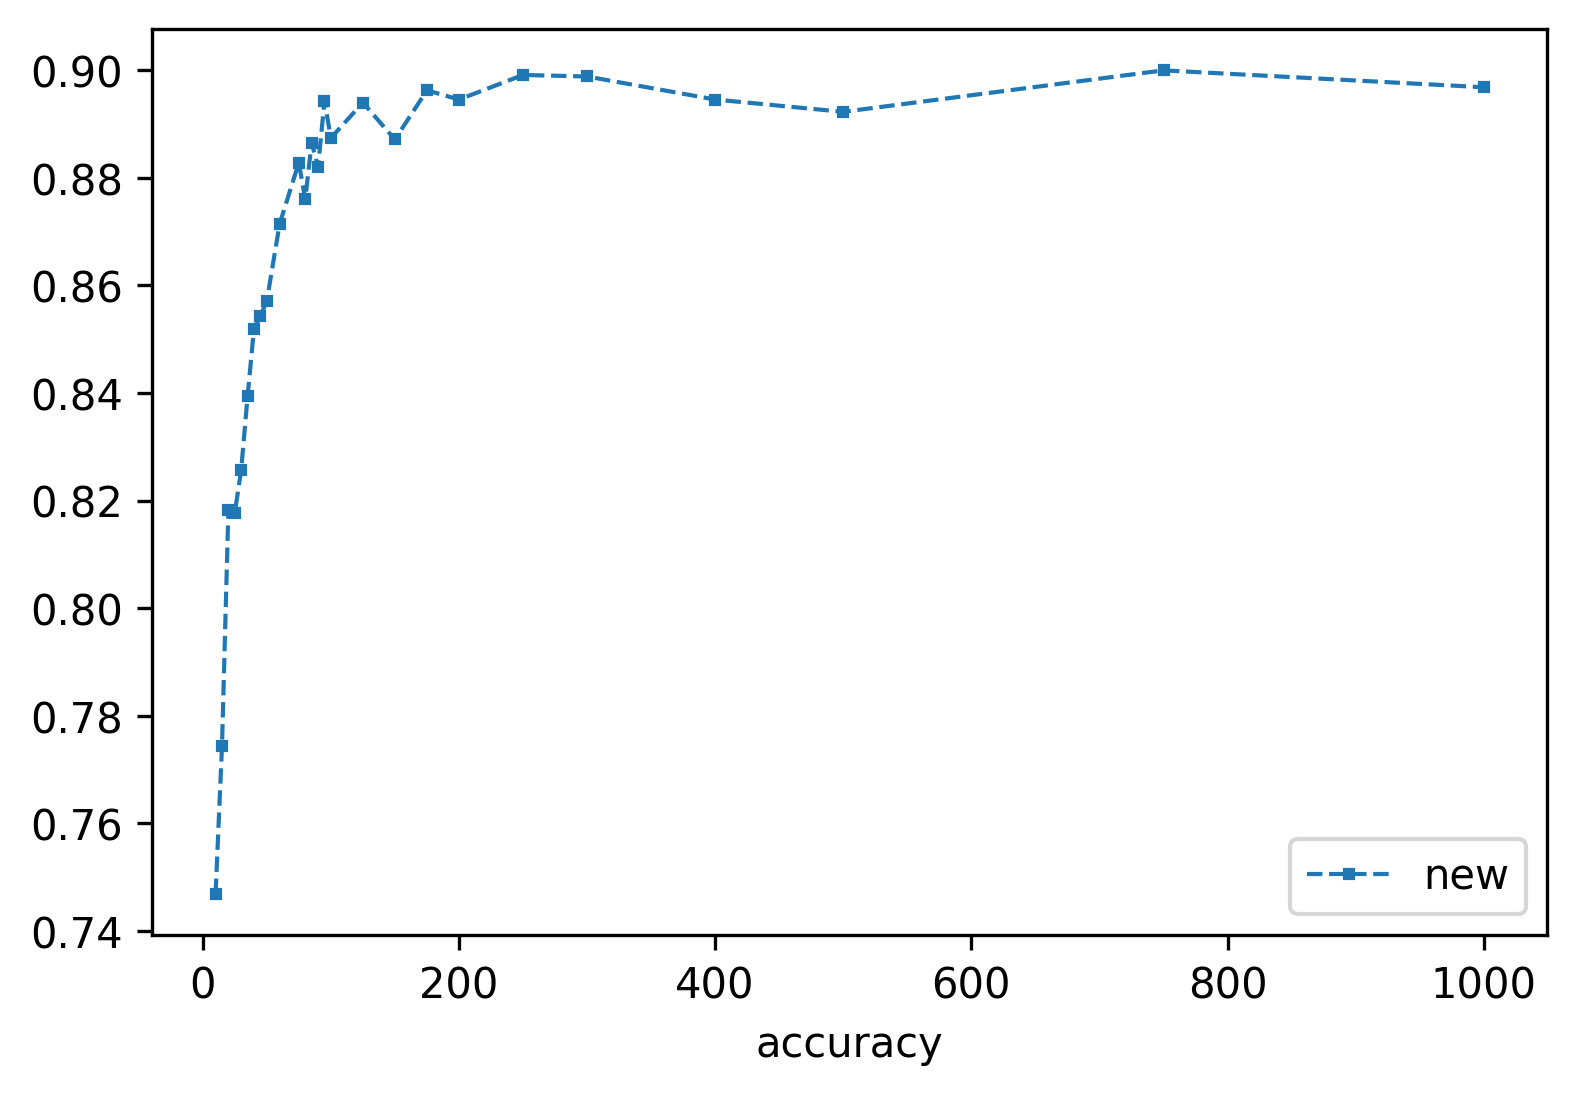

In [10]:
mpl.rcParams['figure.dpi'] = 300

plt.plot(num_tasks, accuracies[7]['new'], label='new',
         marker='s', linestyle='--', linewidth=1, markersize=2)
# plt.plot(num_tasks, accuracies[7]['old greedy'], label='old',
#          marker='s', linestyle='--', linewidth=1, markersize=2)
plt.xlabel('number of tasks')
plt.xlabel('accuracy')
plt.legend()
plt.show()

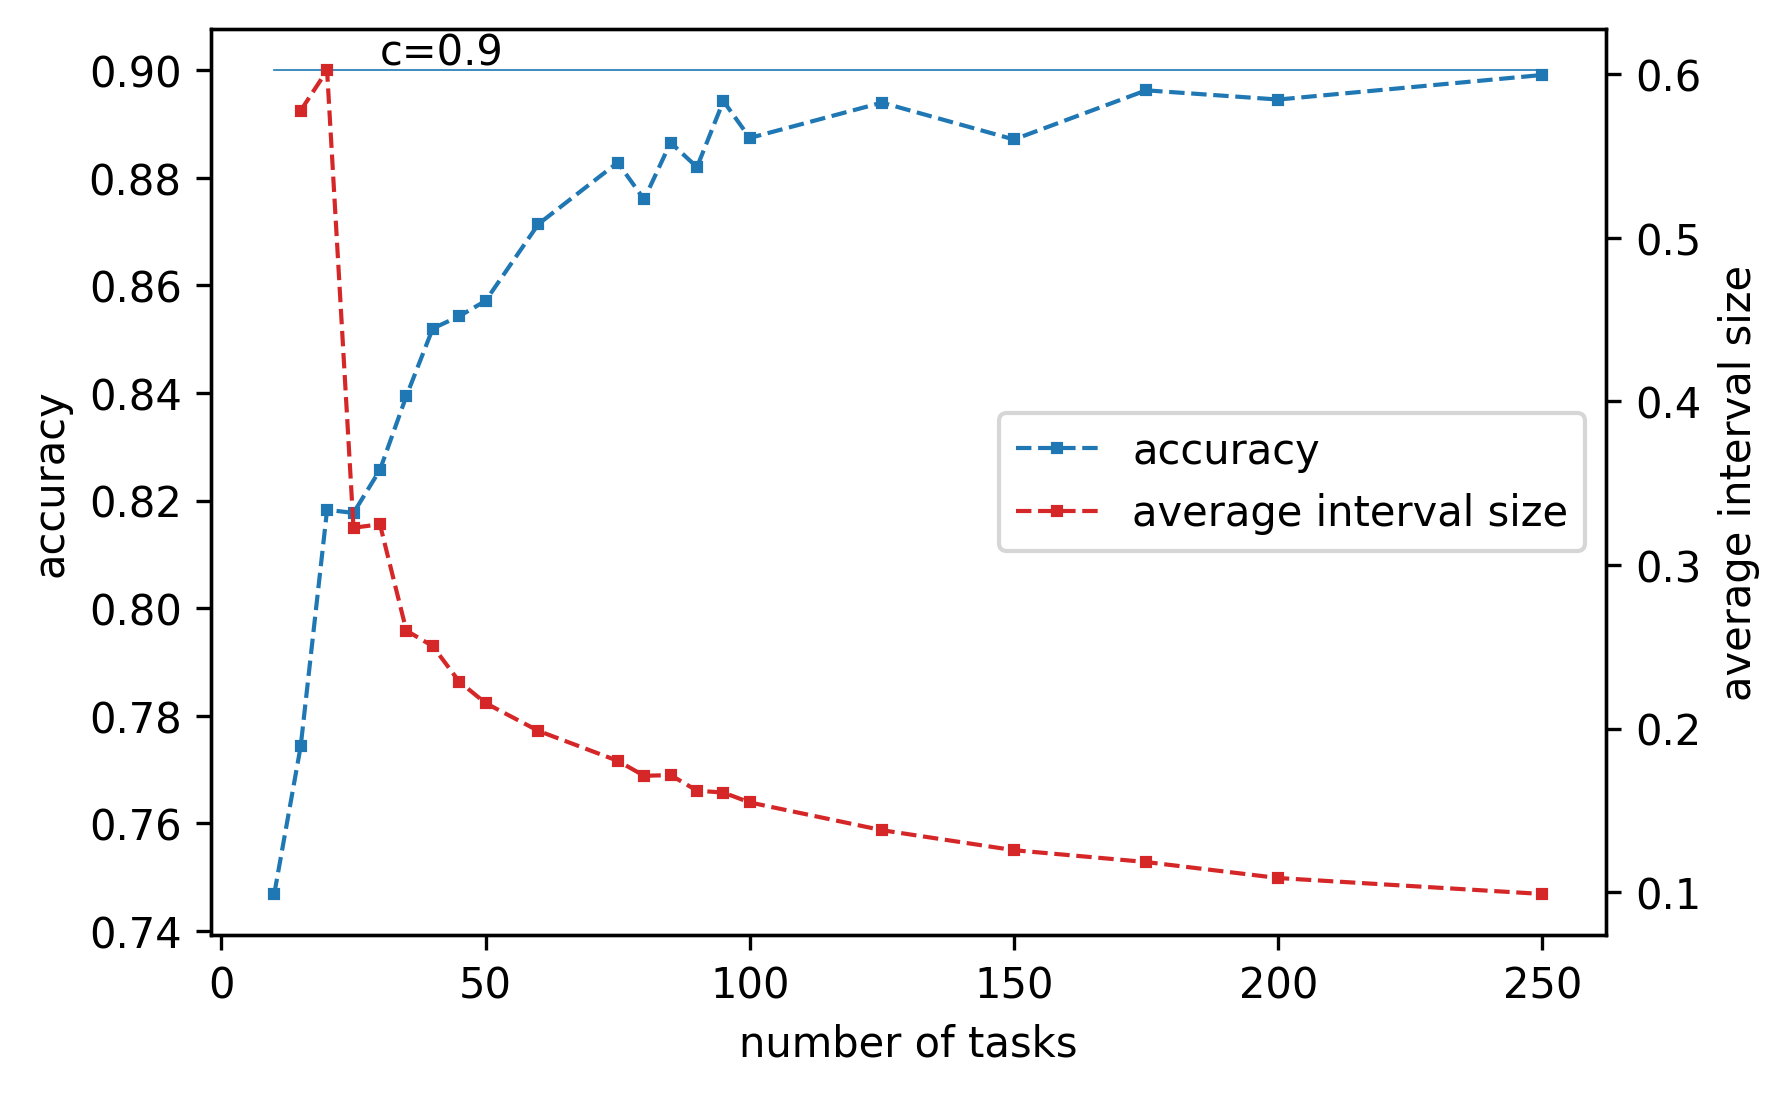

In [44]:
fig, ax1 = plt.subplots()

s = slice(0, len(num_tasks)-5)

color = 'tab:blue'
ax1.set_xlabel('number of tasks')
ax1.set_ylabel('accuracy')
lns1 = ax1.plot(num_tasks[s], accuracies[7]['new'][s], label='accuracy',
         color=color, marker='s', linestyle='--', linewidth=1, markersize=2)
ax1.plot(num_tasks[s], np.full(s.stop-s.start, confidence_level), color=color, linewidth=0.4)
ax1.annotate('c=0.9', (30, 0.901))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('average interval size')  # we already handled the x-label with ax1
lns2 = ax2.plot(num_tasks[s], average_interval_sizes[7]['new'][s], label='average interval size',
         color=color, marker='s', linestyle='--', linewidth=1, markersize=2)

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")

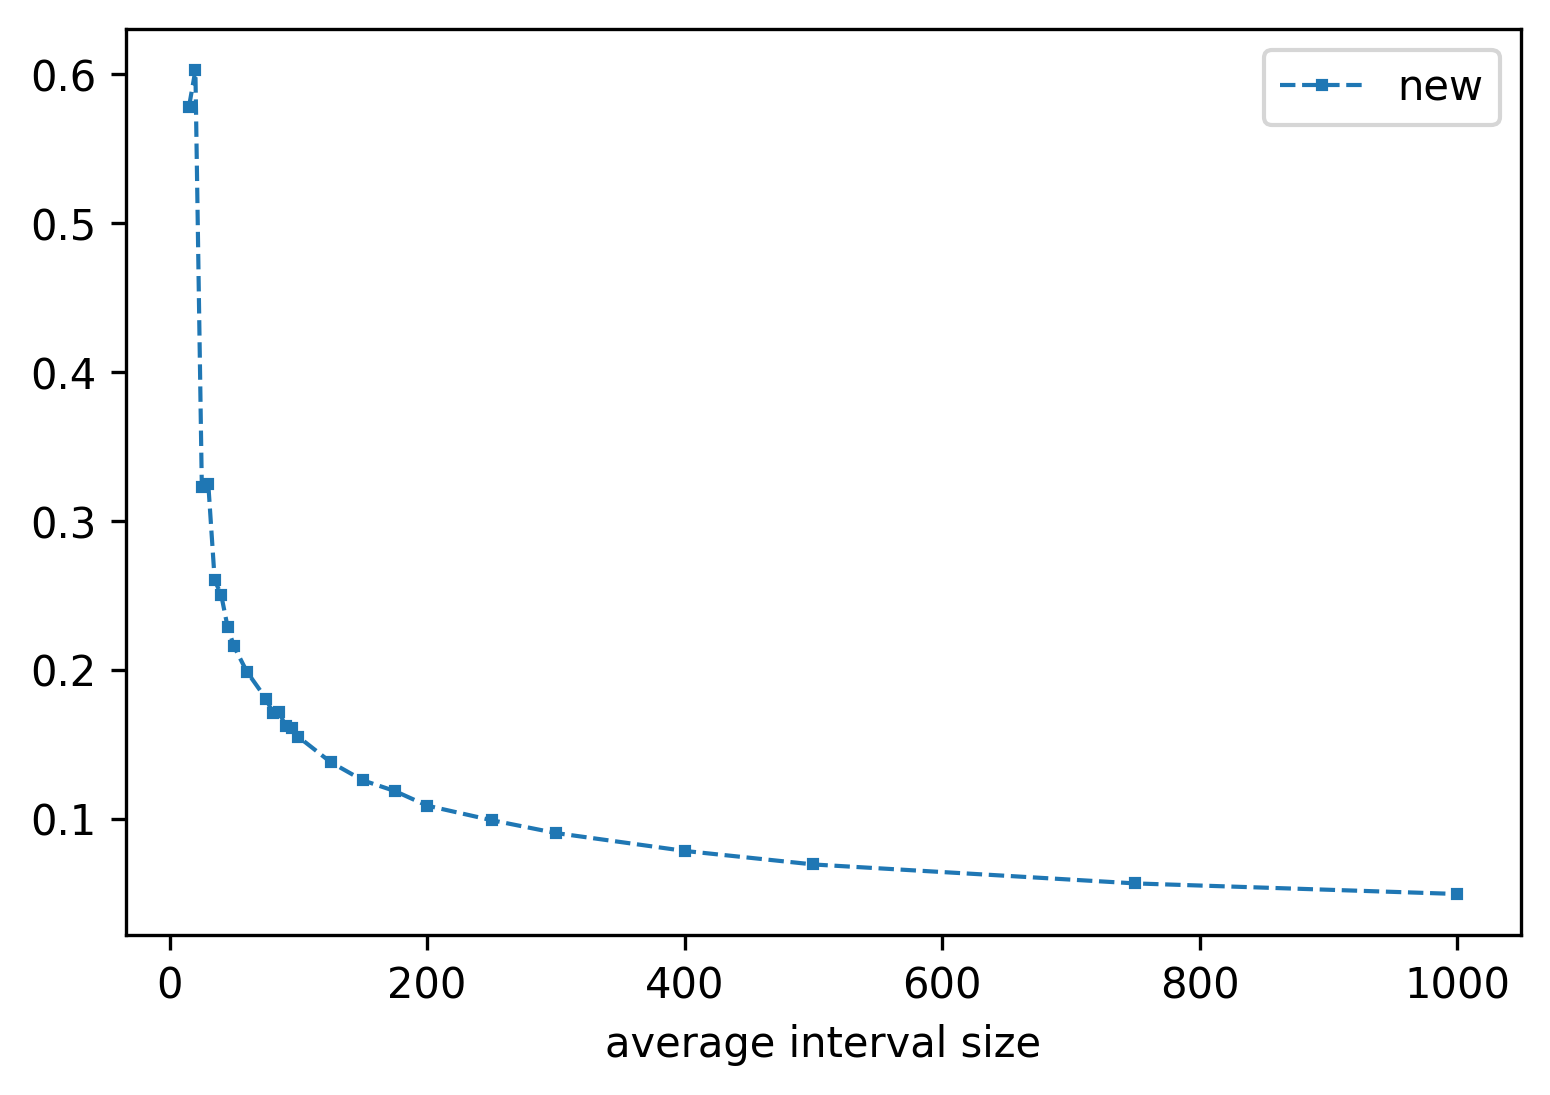

In [9]:
plt.plot(num_tasks, average_interval_sizes[7]['new'], label='new',
         marker='s', linestyle='--', linewidth=1, markersize=2)
# plt.plot(num_tasks, average_interval_sizes[7]['old greedy'], label='old',
#          marker='s', linestyle='--', linewidth=1, markersize=2)
plt.xlabel('number of tasks')
plt.xlabel('average interval size')
plt.legend()
plt.show()